In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.listdir('data')

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']

In [562]:
housing = pd.read_csv('data/train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [563]:
# Split description of features into a dictionary of feature_name:feature_description
import re

with open('data/data_description.txt') as f:
    txt = f.read()

delim = '<--split-->'
lst_features = re.split(delim, re.sub(r'\n(\w)', delim + r'\1', txt))

dct_features = {}
for feature in lst_features:
    split_desc = feature.split(':')
    feature_name = split_desc[0]
    feature_description = ':'.join(split_desc[1:])
    dct_features[feature_name] = feature_description

In [564]:
# Calculate correlation between SalePrice and numeric features
# Correlation with and without dropping 0s is calculated
# Returns 0 if the feature is categorical

y_corr = {}
for feature in housing.drop('SalePrice', axis=1).drop('Id', axis=1).columns:
    if housing[feature].dtype != 'O':
        filtered_set = housing[housing[feature] != 0]
        corr_matrix = housing[['SalePrice', feature]].corr()
        corr_matrix2 = filtered_set[['SalePrice', feature]].corr()
        y_corr[feature] = (corr_matrix.loc['SalePrice', feature], corr_matrix2.loc['SalePrice', feature])
    else:
        y_corr[feature] = (0, 0)
        
y_corr = pd.DataFrame.from_dict(y_corr, orient='index', columns=['corr', 'nozero'])
y_corr

,corr,nozero
MSSubClass,-0.084284,-0.084284
MSZoning,0.000000,0.000000
LotFrontage,0.351799,0.351799
LotArea,0.263843,0.263843
Street,0.000000,0.000000
...,...,...
MiscVal,-0.021190,0.088963
MoSold,0.046432,0.046432
YrSold,-0.028923,-0.028923
SaleType,0.000000,0.000000


OverallQual:  Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
10 unique values
Correlation with sale price:
 corr      0.790982
nozero    0.790982
Name: OverallQual, dtype: float64


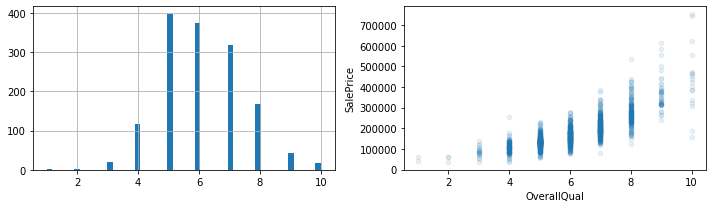

GrLivArea:  Above grade (ground) living area square feet

861 unique values
Correlation with sale price:
 corr      0.708624
nozero    0.708624
Name: GrLivArea, dtype: float64


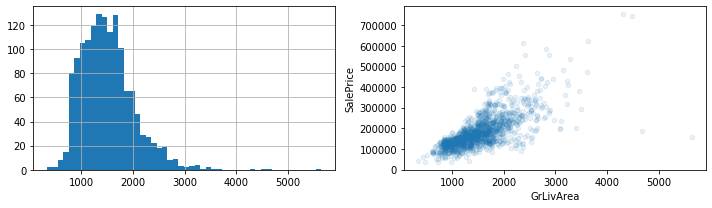

2ndFlrSF:  Second floor square feet

417 unique values
Correlation with sale price:
 corr      0.319334
nozero    0.673305
Name: 2ndFlrSF, dtype: float64


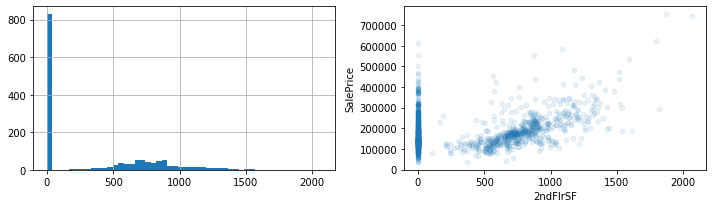

GarageCars:  Size of garage in car capacity

5 unique values
Correlation with sale price:
 corr      0.640409
nozero    0.637095
Name: GarageCars, dtype: float64


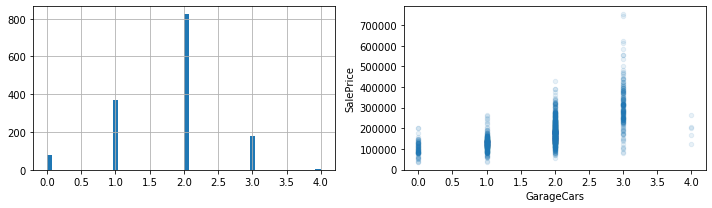

TotalBsmtSF:  Total square feet of basement area

721 unique values
Correlation with sale price:
 corr      0.613581
nozero    0.609681
Name: TotalBsmtSF, dtype: float64


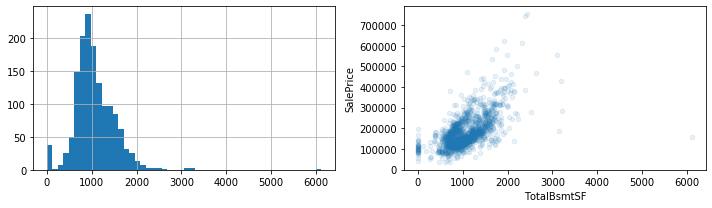

GarageArea:  Size of garage in square feet

441 unique values
Correlation with sale price:
 corr      0.623431
nozero    0.608405
Name: GarageArea, dtype: float64


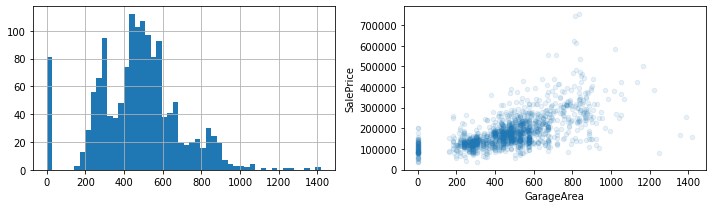

1stFlrSF:  First Floor square feet
 
753 unique values
Correlation with sale price:
 corr      0.605852
nozero    0.605852
Name: 1stFlrSF, dtype: float64


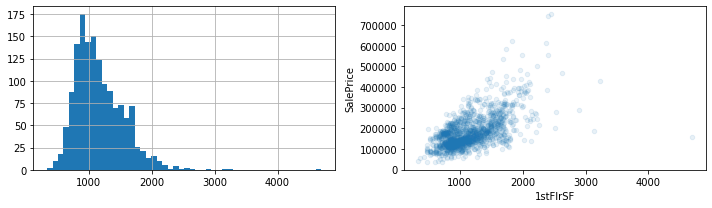

FullBath:  Full bathrooms above grade

4 unique values
Correlation with sale price:
 corr      0.560664
nozero    0.574563
Name: FullBath, dtype: float64


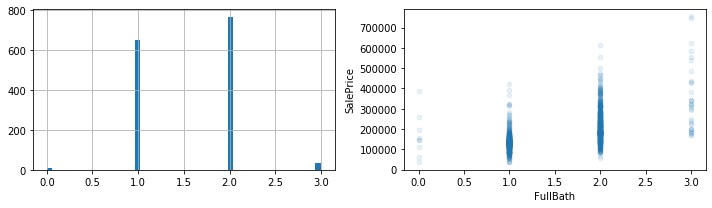

TotRmsAbvGrd:  Total rooms above grade (does not include bathrooms)

12 unique values
Correlation with sale price:
 corr      0.533723
nozero    0.533723
Name: TotRmsAbvGrd, dtype: float64


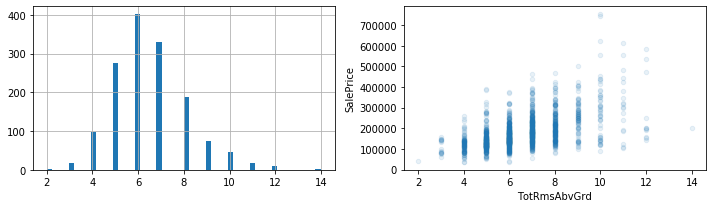

YearBuilt:  Original construction date

112 unique values
Correlation with sale price:
 corr      0.522897
nozero    0.522897
Name: YearBuilt, dtype: float64


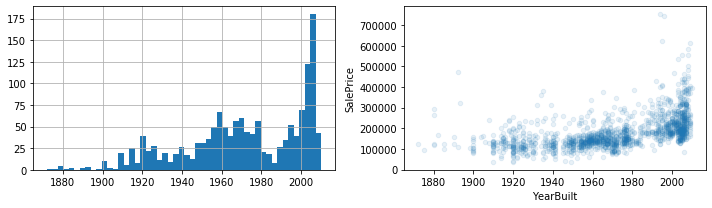

YearRemodAdd:  Remodel date (same as construction date if no remodeling or additions)

61 unique values
Correlation with sale price:
 corr      0.507101
nozero    0.507101
Name: YearRemodAdd, dtype: float64


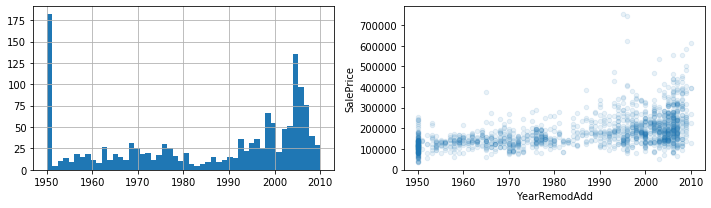

GarageYrBlt:  Year garage was built
		
97 unique values
Correlation with sale price:
 corr      0.486362
nozero    0.486362
Name: GarageYrBlt, dtype: float64


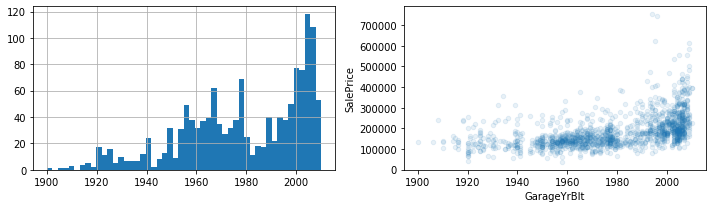

BsmtFinSF1:  Type 1 finished square feet

637 unique values
Correlation with sale price:
 corr      0.38642
nozero    0.47169
Name: BsmtFinSF1, dtype: float64


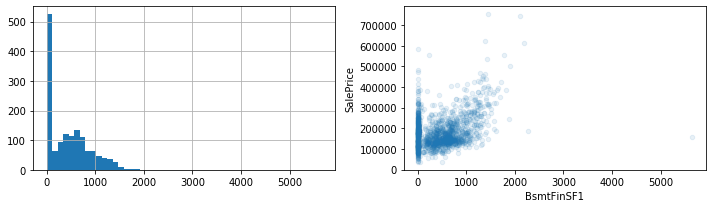

MasVnrArea:  Masonry veneer area in square feet

327 unique values
Correlation with sale price:
 corr      0.477493
nozero    0.434090
Name: MasVnrArea, dtype: float64


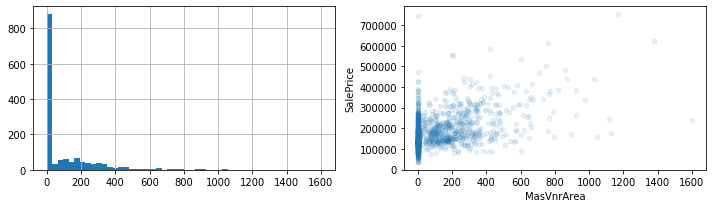

LotFrontage:  Linear feet of street connected to property

110 unique values
Correlation with sale price:
 corr      0.351799
nozero    0.351799
Name: LotFrontage, dtype: float64


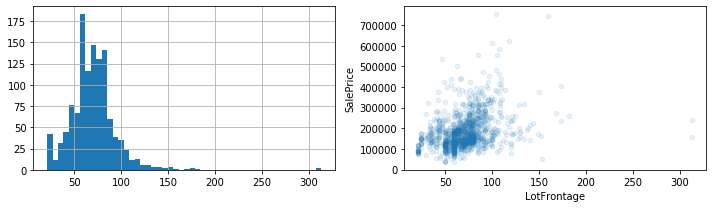

LowQualFinSF:  Low quality finished square feet (all floors)

24 unique values
Correlation with sale price:
 corr     -0.025606
nozero    0.300075
Name: LowQualFinSF, dtype: float64


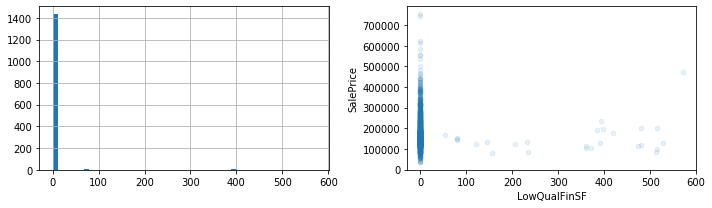

LotArea:  Lot size in square feet

1073 unique values
Correlation with sale price:
 corr      0.263843
nozero    0.263843
Name: LotArea, dtype: float64


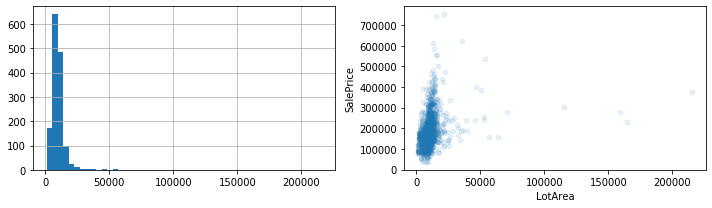

ScreenPorch:  Screen porch area in square feet

76 unique values
Correlation with sale price:
 corr      0.111447
nozero    0.255430
Name: ScreenPorch, dtype: float64


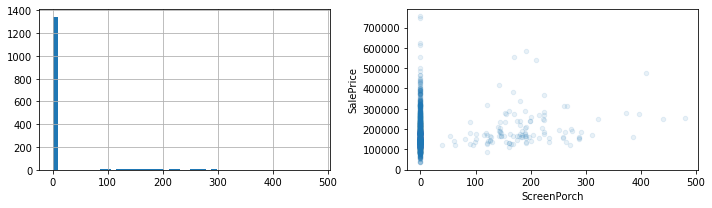

EnclosedPorch:  Enclosed porch area in square feet

120 unique values
Correlation with sale price:
 corr     -0.128578
nozero    0.241279
Name: EnclosedPorch, dtype: float64


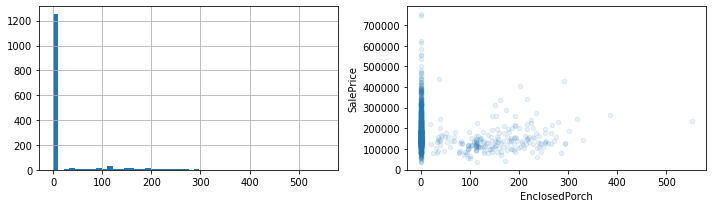

BsmtFinSF2:  Type 2 finished square feet

144 unique values
Correlation with sale price:
 corr     -0.011378
nozero    0.198956
Name: BsmtFinSF2, dtype: float64


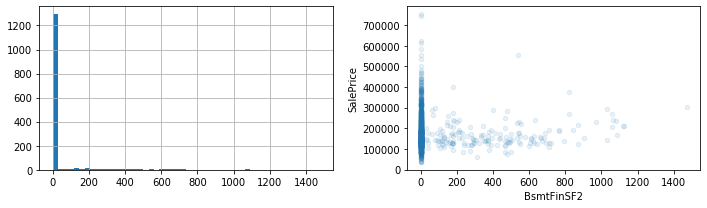

WoodDeckSF:  Wood deck area in square feet

274 unique values
Correlation with sale price:
 corr      0.324413
nozero    0.193706
Name: WoodDeckSF, dtype: float64


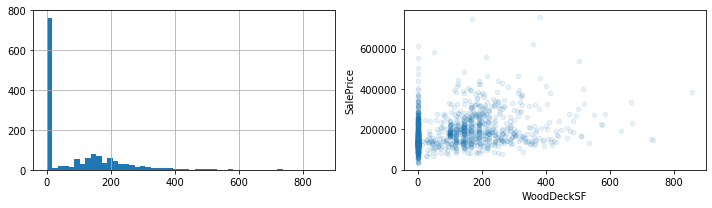

BedroomAbvGr
8 unique values
Correlation with sale price:
 corr      0.168213
nozero    0.180937
Name: BedroomAbvGr, dtype: float64


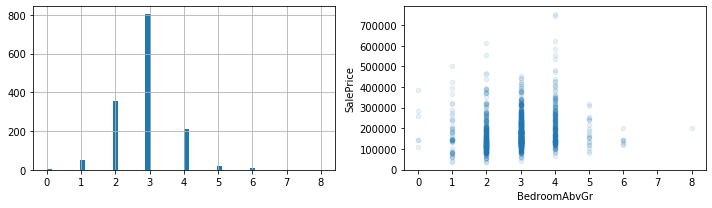

BsmtUnfSF:  Unfinished square feet of basement area

780 unique values
Correlation with sale price:
 corr      0.214479
nozero    0.169261
Name: BsmtUnfSF, dtype: float64


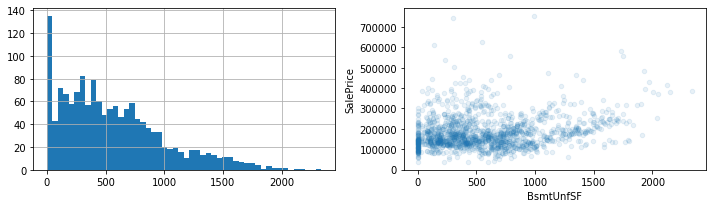

Fireplaces:  Number of fireplaces

4 unique values
Correlation with sale price:
 corr      0.466929
nozero    0.121661
Name: Fireplaces, dtype: float64


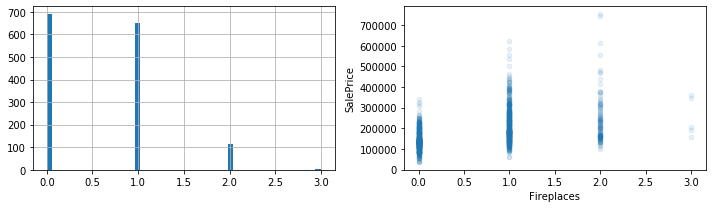

MiscVal:  $Value of miscellaneous feature

21 unique values
Correlation with sale price:
 corr     -0.021190
nozero    0.088963
Name: MiscVal, dtype: float64


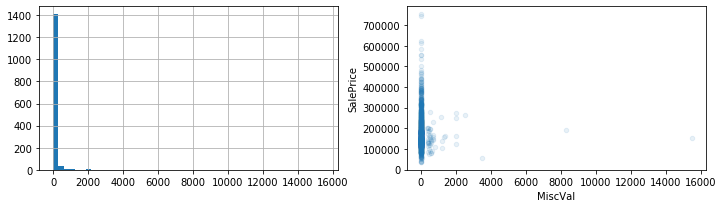

OpenPorchSF:  Open porch area in square feet

202 unique values
Correlation with sale price:
 corr      0.315856
nozero    0.086453
Name: OpenPorchSF, dtype: float64


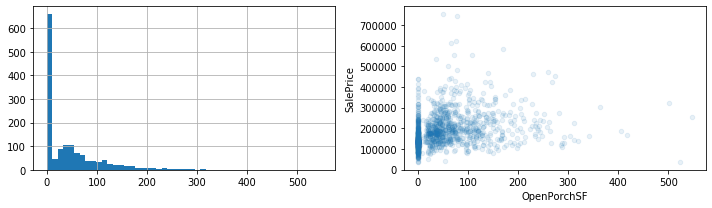

3SsnPorch:  Three season porch area in square feet

20 unique values
Correlation with sale price:
 corr      0.044584
nozero    0.063932
Name: 3SsnPorch, dtype: float64


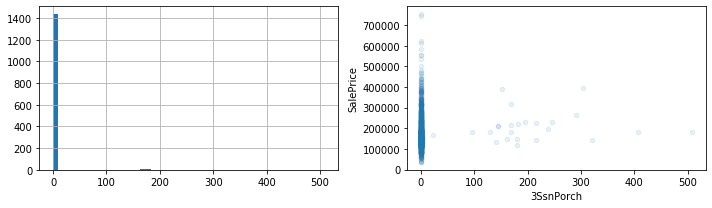

MoSold:  Month Sold (MM)

12 unique values
Correlation with sale price:
 corr      0.046432
nozero    0.046432
Name: MoSold, dtype: float64


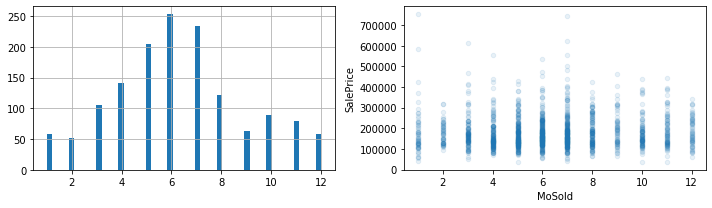

BsmtFullBath:  Basement full bathrooms

4 unique values
Correlation with sale price:
 corr      0.227122
nozero    0.011439
Name: BsmtFullBath, dtype: float64


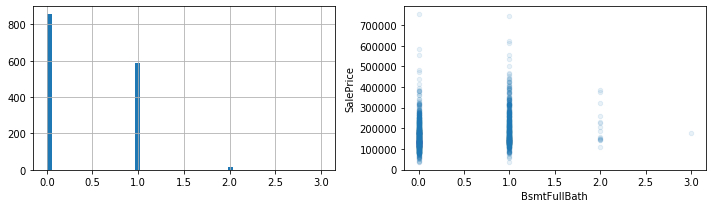

RoofStyle:  Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: RoofStyle, dtype: float64


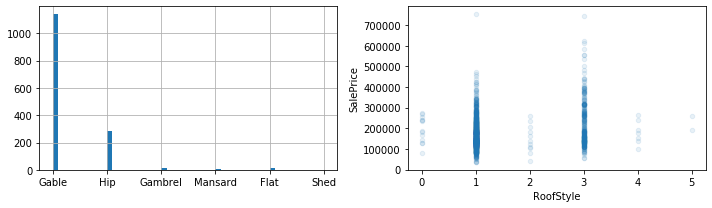

RoofMatl:  Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
8 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: RoofMatl, dtype: float64


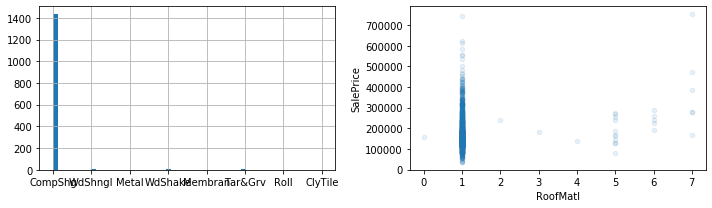

MasVnrType:  Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: MasVnrType, dtype: float64


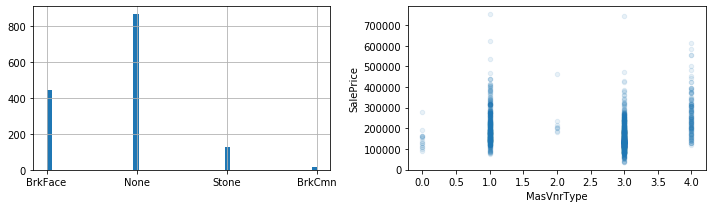

Exterior2nd:  Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
16 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Exterior2nd, dtype: float64


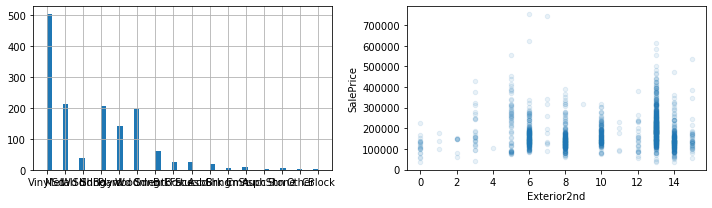

Exterior1st:  Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
15 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Exterior1st, dtype: float64


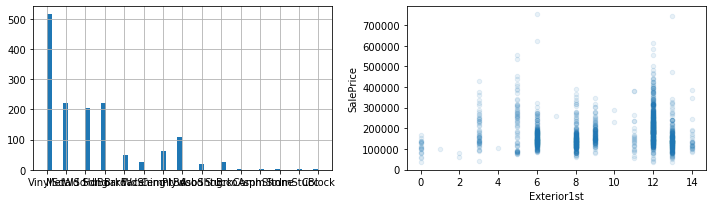

SaleCondition:  Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: SaleCondition, dtype: float64


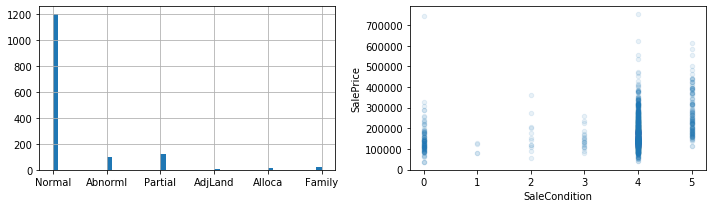

HouseStyle:  Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
8 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: HouseStyle, dtype: float64


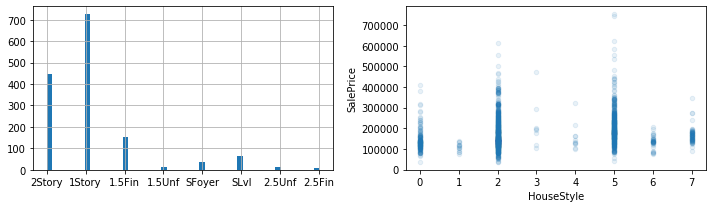

BldgType:  Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BldgType, dtype: float64


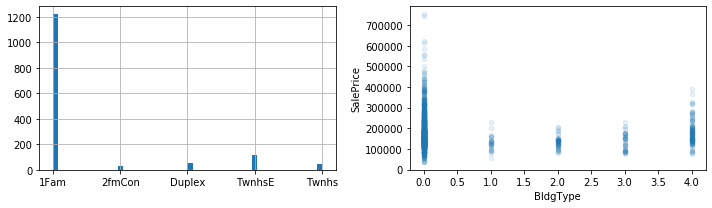

Condition2:  Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
8 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Condition2, dtype: float64


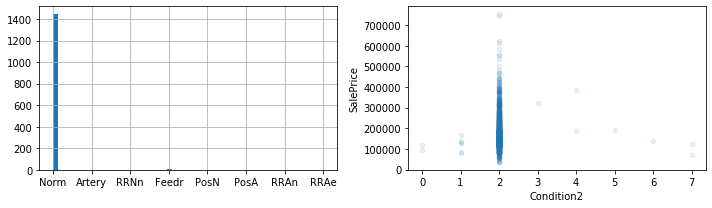

ExterCond:  Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: ExterCond, dtype: float64


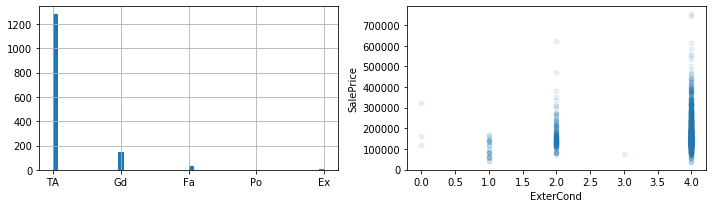

Condition1:  Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
9 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Condition1, dtype: float64


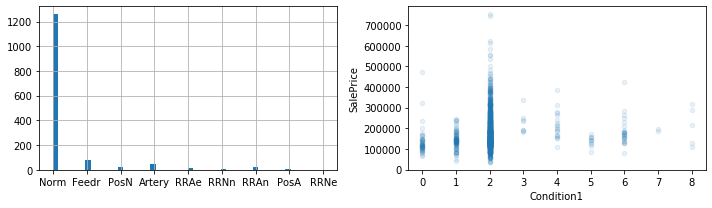

Neighborhood:  Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
25 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Neighborhood, dtype: float64


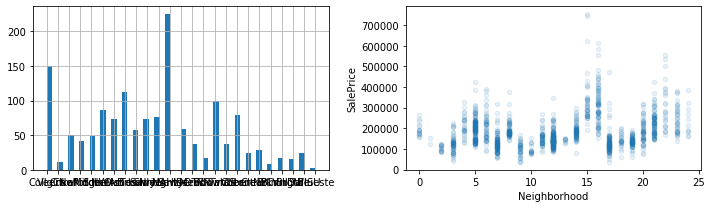

LandSlope:  Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
3 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: LandSlope, dtype: float64


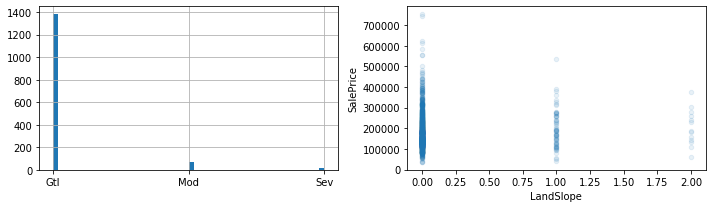

LotConfig:  Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: LotConfig, dtype: float64


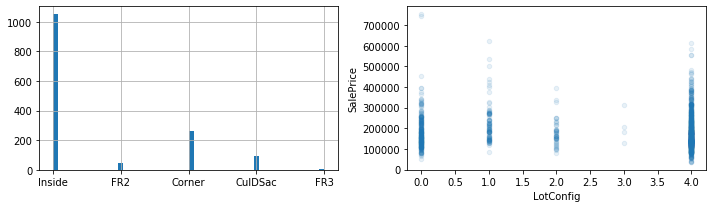

Utilities:  Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
2 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Utilities, dtype: float64


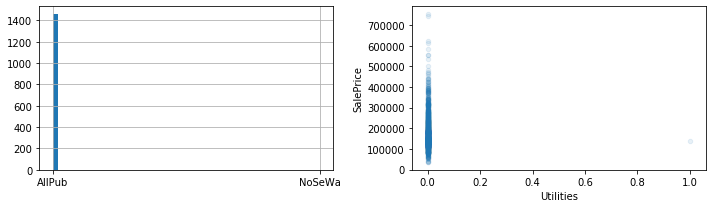

LandContour:  Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: LandContour, dtype: float64


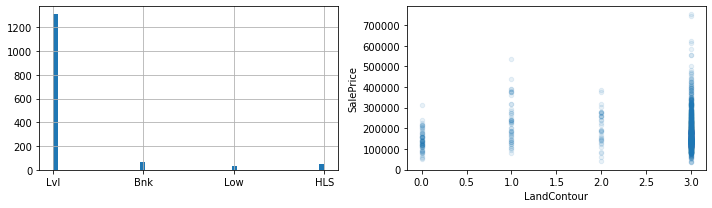

LotShape:  General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: LotShape, dtype: float64


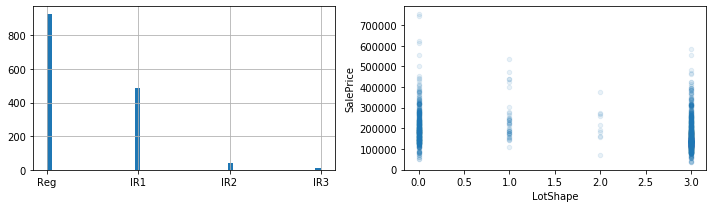

Alley:  Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
2 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Alley, dtype: float64


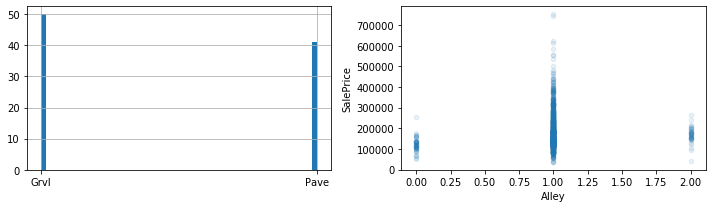

Street:  Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
2 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Street, dtype: float64


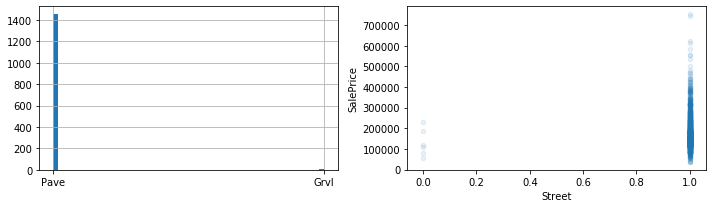

MSZoning:  Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: MSZoning, dtype: float64


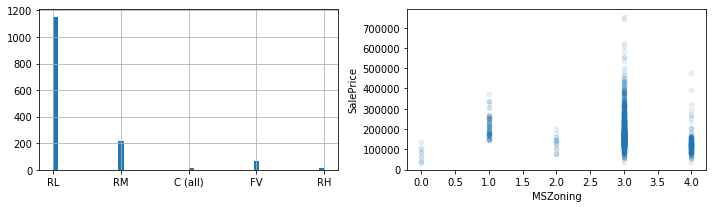

ExterQual:  Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: ExterQual, dtype: float64


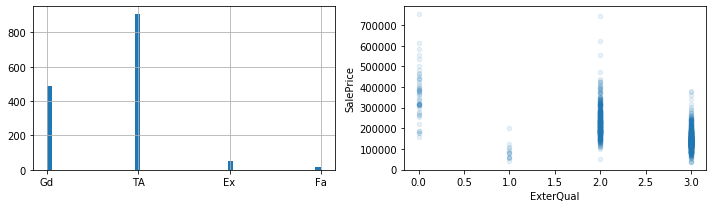

HeatingQC:  Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: HeatingQC, dtype: float64


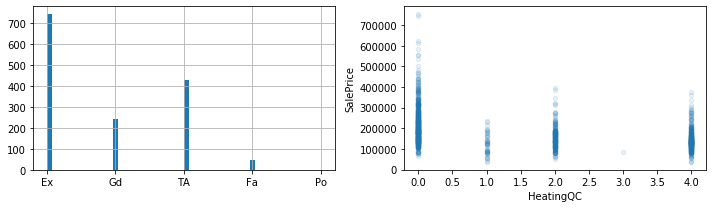

Foundation:  Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Foundation, dtype: float64


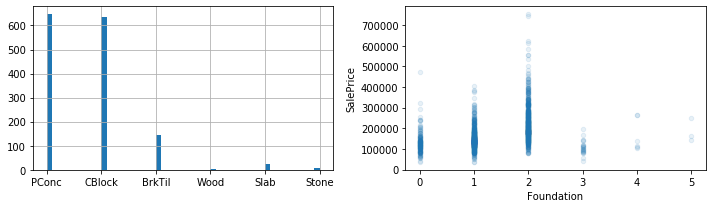

BsmtQual:  Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtQual, dtype: float64


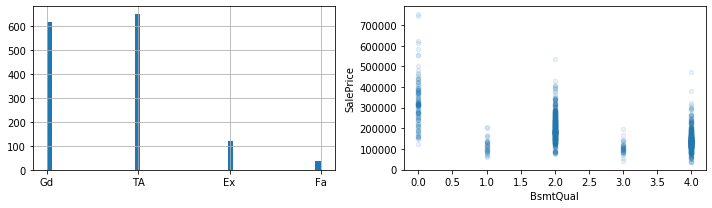

MiscFeature:  Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: MiscFeature, dtype: float64


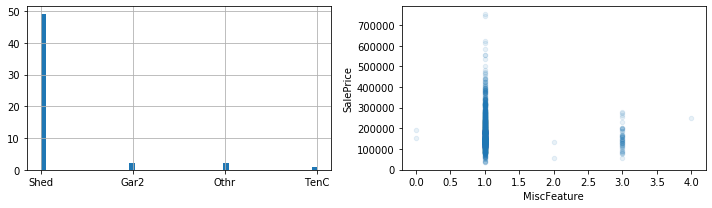

Fence:  Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Fence, dtype: float64


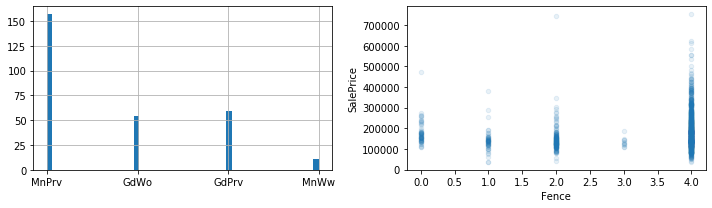

PoolQC:  Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
3 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: PoolQC, dtype: float64


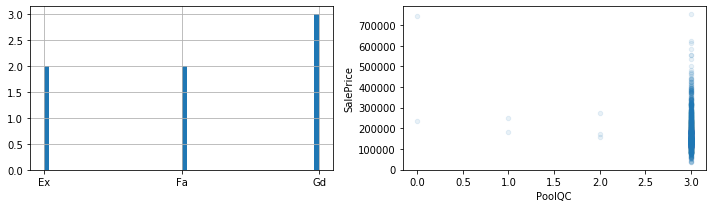

PavedDrive:  Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
3 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: PavedDrive, dtype: float64


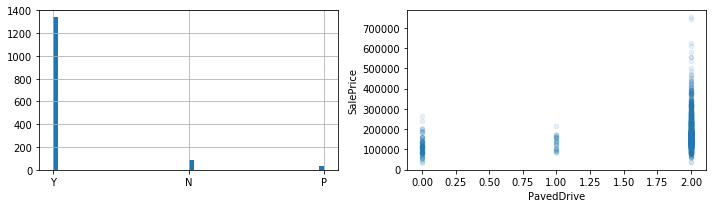

GarageCond:  Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: GarageCond, dtype: float64


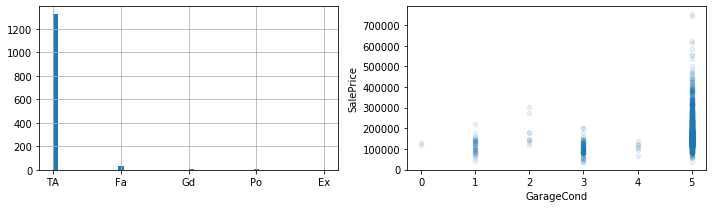

GarageQual:  Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: GarageQual, dtype: float64


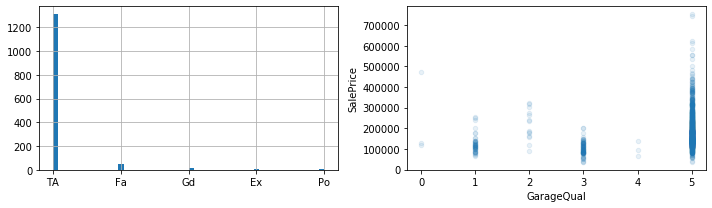

GarageFinish:  Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
3 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: GarageFinish, dtype: float64


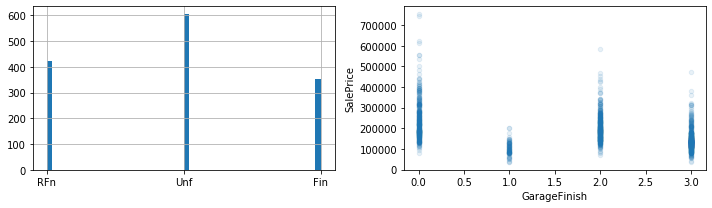

GarageType:  Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: GarageType, dtype: float64


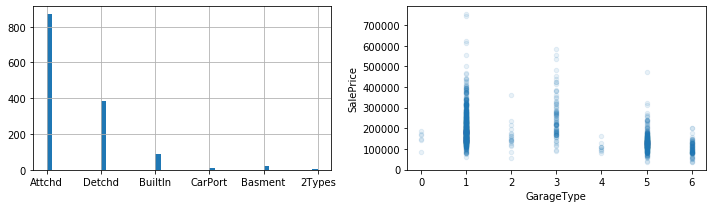

FireplaceQu:  Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: FireplaceQu, dtype: float64


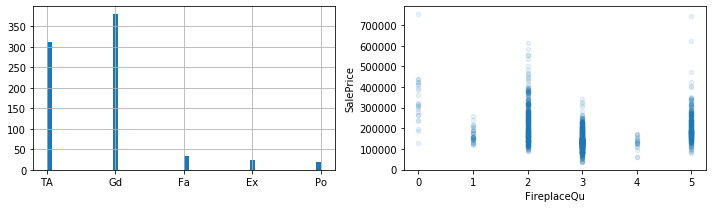

Functional:  Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
7 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Functional, dtype: float64


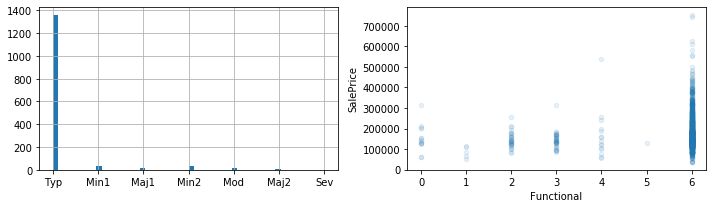

KitchenQual:  Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: KitchenQual, dtype: float64


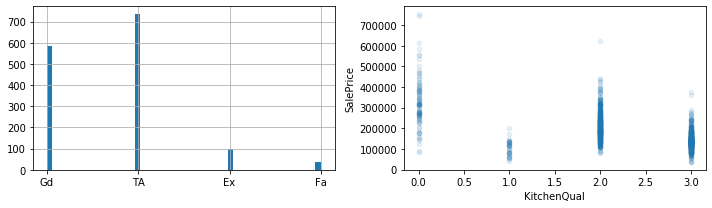

Electrical:  Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		
5 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Electrical, dtype: float64


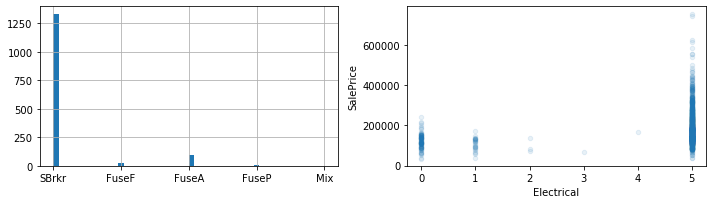

CentralAir:  Central air conditioning

       N	No
       Y	Yes
		
2 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: CentralAir, dtype: float64


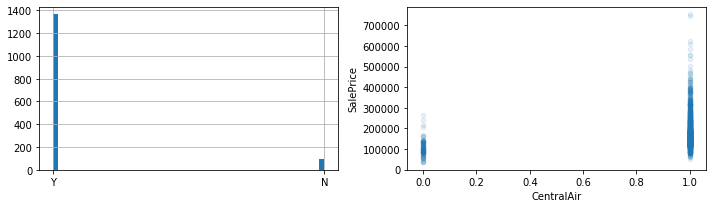

SaleType:  Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
9 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: SaleType, dtype: float64


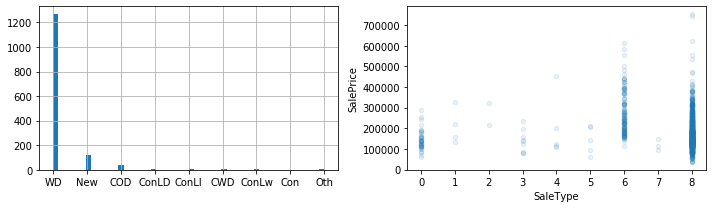

Heating:  Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Heating, dtype: float64


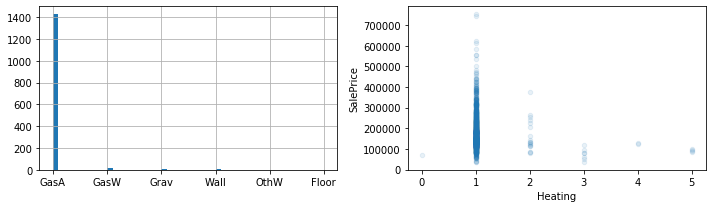

BsmtFinType2:  Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtFinType2, dtype: float64


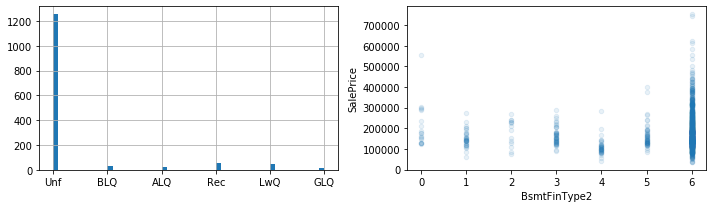

BsmtFinType1:  Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtFinType1, dtype: float64


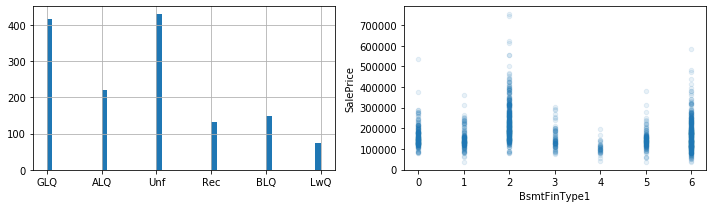

BsmtExposure:  Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtExposure, dtype: float64


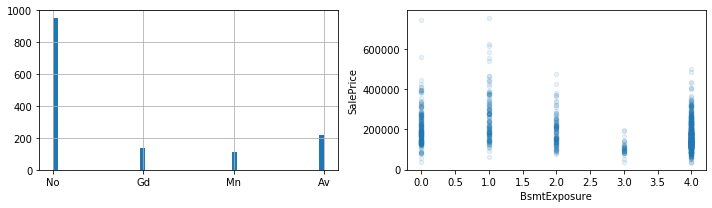

BsmtCond:  Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtCond, dtype: float64


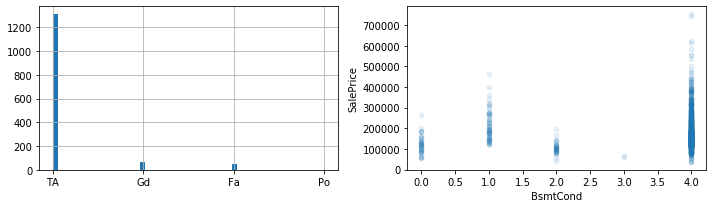

PoolArea:  Pool area in square feet

8 unique values
Correlation with sale price:
 corr      0.092404
nozero   -0.014092
Name: PoolArea, dtype: float64


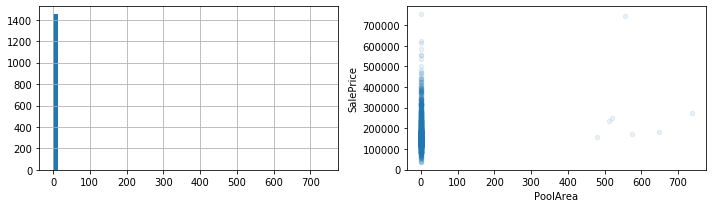

BsmtHalfBath:  Basement half bathrooms

3 unique values
Correlation with sale price:
 corr     -0.016844
nozero   -0.028835
Name: BsmtHalfBath, dtype: float64


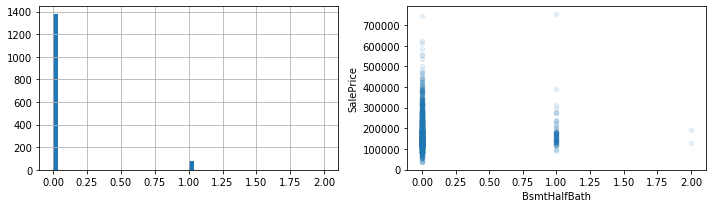

Keep feature? y/nn
YrSold:  Year Sold (YYYY)

5 unique values
Correlation with sale price:
 corr     -0.028923
nozero   -0.028923
Name: YrSold, dtype: float64


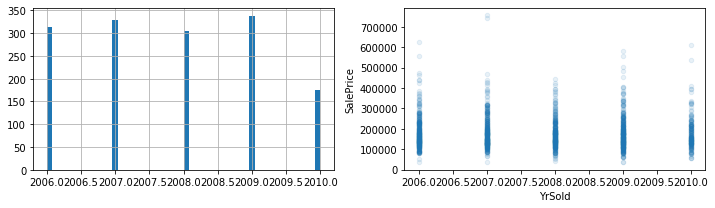

Keep feature? y/nn
OverallCond:  Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		
9 unique values
Correlation with sale price:
 corr     -0.077856
nozero   -0.077856
Name: OverallCond, dtype: float64


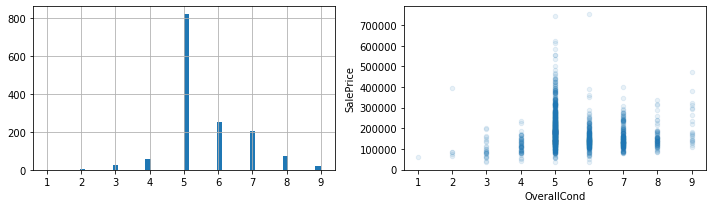

Keep feature? y/nn
MSSubClass:  Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

15 unique values
Correlation with sale price:
 corr     -0.084284
nozero   -0.084284
Name: MSSubClass, dtype: float64


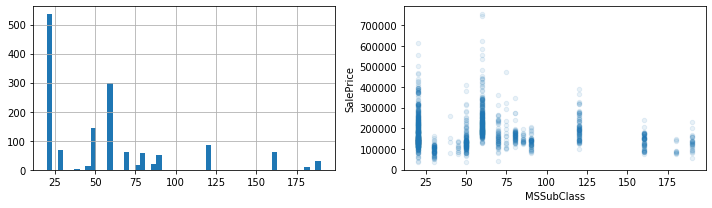

Keep feature? y/ny
HalfBath:  Half baths above grade

3 unique values
Correlation with sale price:
 corr      0.284108
nozero   -0.084392
Name: HalfBath, dtype: float64


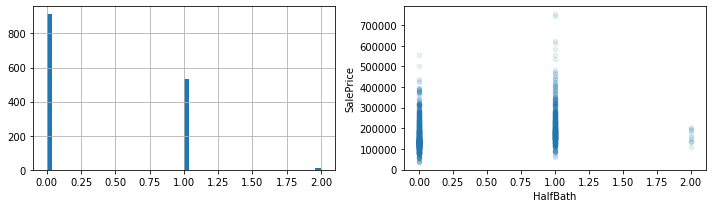

Keep feature? y/nn
KitchenAbvGr
4 unique values
Correlation with sale price:
 corr     -0.135907
nozero   -0.139201
Name: KitchenAbvGr, dtype: float64


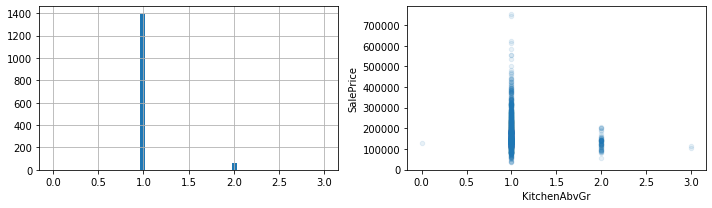

Keep feature? y/nn


In [232]:
# Display description, statistics and feature plots all in one frame
# dct_keep is used to determine whether to keep this feature or not

# %matplotlib inline

# from sklearn.preprocessing import LabelEncoder

# nunique_values = housing.nunique().sort_values(ascending=False)

# dct_keep = {}

# for feature_name, corrs in y_corr['nozero'].sort_values(ascending=False).iteritems():

#     # Print feature description, number of unique values and correlation with sale price
#     if feature_name in dct_features.keys():
#          print('%s: %s' % (feature_name, dct_features[feature_name]))
#     else:
#          print(feature_name)
#     print('%s unique values' % nunique_values[feature_name])
#     print('Correlation with sale price:\n', y_corr.loc[feature_name])
    
#     # Plot
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
#     # Figure 1 (left)
#     housing[feature_name].hist(bins=50, ax=ax[0])
    
#     # Figure 2 (right)
#     if housing[feature_name].dtype != 'O':
#         housing.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
#     else:
#         le = LabelEncoder()
#         encoded_feature = pd.DataFrame(
#             {'SalePrice': housing['SalePrice'],
#              feature_name: le.fit_transform(housing[feature_name].fillna('NA') )
#             })
        
#         encoded_feature.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
    
#     plt.tight_layout()
#     plt.show()

#     # Keep?
#     dct_keep[feature_name] = input('Keep feature? y/n')

In [565]:
s_dct_keep = pd.Series(dct_keep, name='to_keep')


s_dct_keep.to_csv('data/features_to_keep.csv', header=True)
s_dct_keep[['ExterQual', 'HeatingQC', 'FireplaceQu', 'Fence', 'GarageQual']] = 'y'
s_dct_keep = s_dct_keep[s_dct_keep == 'y']
to_keep = s_dct_keep.index

# Now using only the selected features

In [566]:
# Filter data 
housing = pd.read_csv('data/train.csv')
housing = housing[['SalePrice'] + list(to_keep)]
housing.columns

pd.set_option('max_rows', None)
nunique_values = housing.nunique().sort_values(ascending=False)
print(nunique_values)
pd.set_option('max_rows', 10)

GrLivArea       861
1stFlrSF        753
TotalBsmtSF     721
SalePrice       663
BsmtFinSF1      637
GarageArea      441
2ndFlrSF        417
YearBuilt       112
GarageYrBlt      97
YearRemodAdd     61
Neighborhood     25
MSSubClass       15
TotRmsAbvGrd     12
OverallQual      10
Foundation        6
GarageQual        5
HeatingQC         5
FireplaceQu       5
GarageCars        5
KitchenQual       4
LandContour       4
Fence             4
BsmtQual          4
ExterQual         4
Fireplaces        4
FullBath          4
dtype: int64


OverallQual:  Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
10 unique values
Correlation with sale price:
 corr      0.790982
nozero    0.790982
Name: OverallQual, dtype: float64


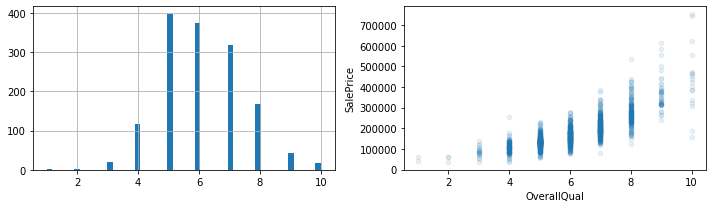

GrLivArea:  Above grade (ground) living area square feet

861 unique values
Correlation with sale price:
 corr      0.708624
nozero    0.708624
Name: GrLivArea, dtype: float64


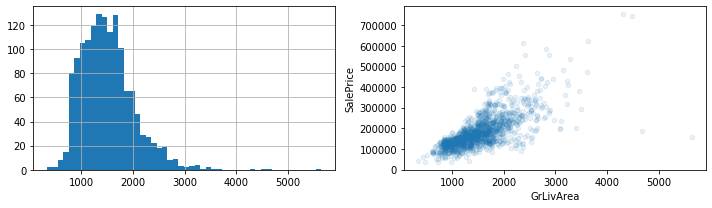

2ndFlrSF:  Second floor square feet

417 unique values
Correlation with sale price:
 corr      0.319334
nozero    0.673305
Name: 2ndFlrSF, dtype: float64


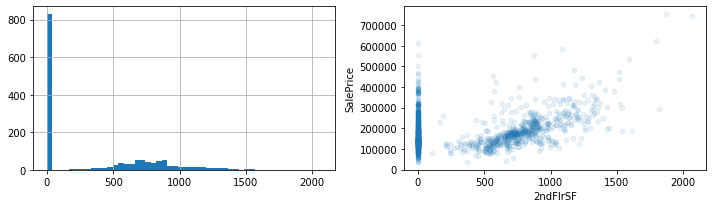

GarageCars:  Size of garage in car capacity

5 unique values
Correlation with sale price:
 corr      0.640409
nozero    0.637095
Name: GarageCars, dtype: float64


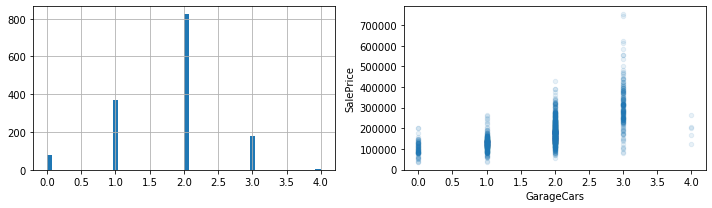

TotalBsmtSF:  Total square feet of basement area

721 unique values
Correlation with sale price:
 corr      0.613581
nozero    0.609681
Name: TotalBsmtSF, dtype: float64


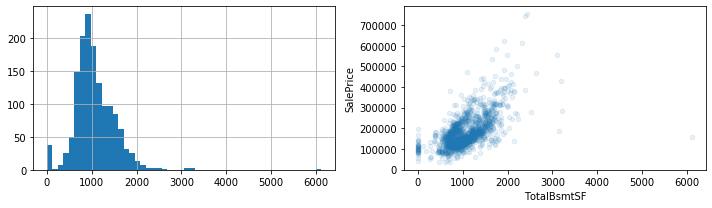

GarageArea:  Size of garage in square feet

441 unique values
Correlation with sale price:
 corr      0.623431
nozero    0.608405
Name: GarageArea, dtype: float64


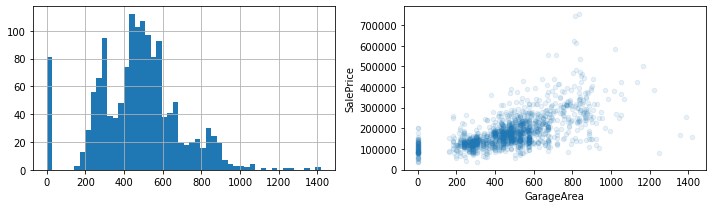

1stFlrSF:  First Floor square feet
 
753 unique values
Correlation with sale price:
 corr      0.605852
nozero    0.605852
Name: 1stFlrSF, dtype: float64


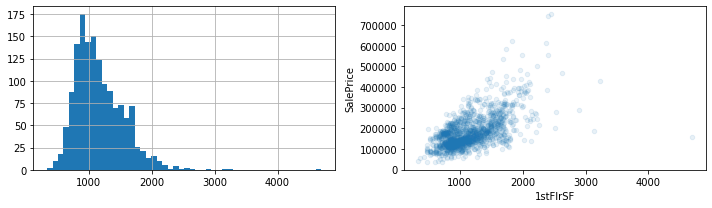

FullBath:  Full bathrooms above grade

4 unique values
Correlation with sale price:
 corr      0.560664
nozero    0.574563
Name: FullBath, dtype: float64


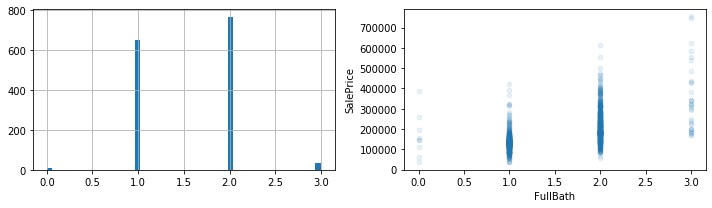

TotRmsAbvGrd:  Total rooms above grade (does not include bathrooms)

12 unique values
Correlation with sale price:
 corr      0.533723
nozero    0.533723
Name: TotRmsAbvGrd, dtype: float64


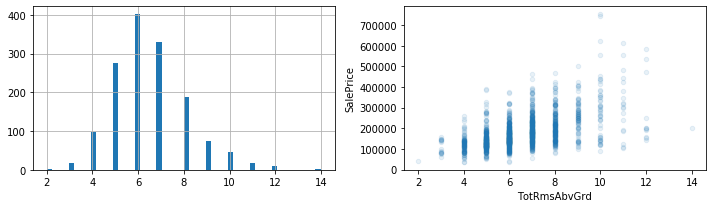

YearBuilt:  Original construction date

112 unique values
Correlation with sale price:
 corr      0.522897
nozero    0.522897
Name: YearBuilt, dtype: float64


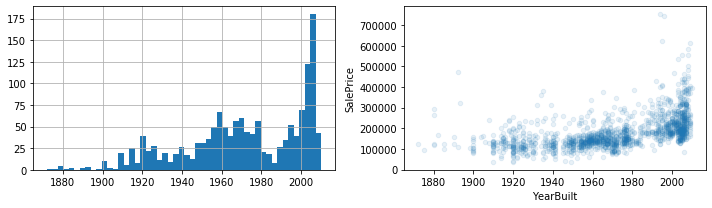

YearRemodAdd:  Remodel date (same as construction date if no remodeling or additions)

61 unique values
Correlation with sale price:
 corr      0.507101
nozero    0.507101
Name: YearRemodAdd, dtype: float64


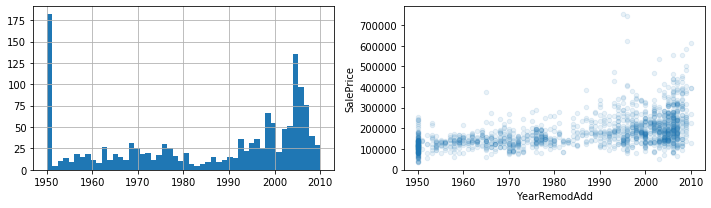

GarageYrBlt:  Year garage was built
		
97 unique values
Correlation with sale price:
 corr      0.486362
nozero    0.486362
Name: GarageYrBlt, dtype: float64


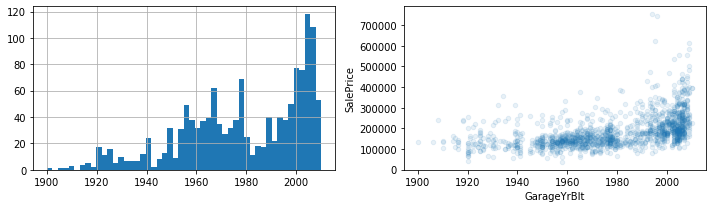

BsmtFinSF1:  Type 1 finished square feet

637 unique values
Correlation with sale price:
 corr      0.38642
nozero    0.47169
Name: BsmtFinSF1, dtype: float64


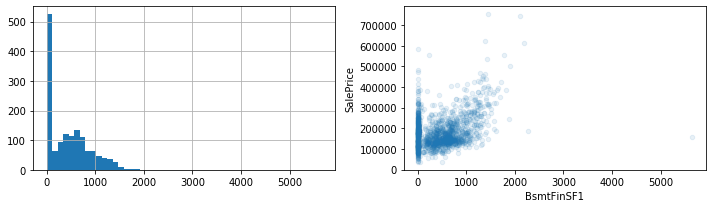

Fireplaces:  Number of fireplaces

4 unique values
Correlation with sale price:
 corr      0.466929
nozero    0.121661
Name: Fireplaces, dtype: float64


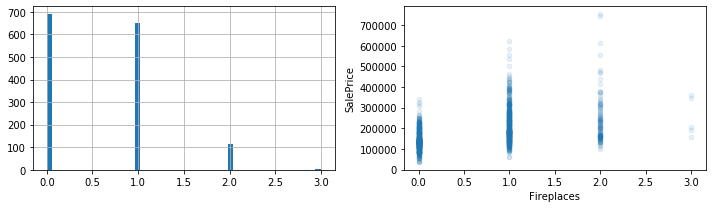

KitchenQual:  Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: KitchenQual, dtype: float64


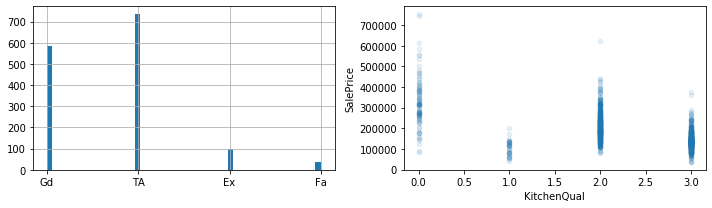

Neighborhood:  Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
25 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Neighborhood, dtype: float64


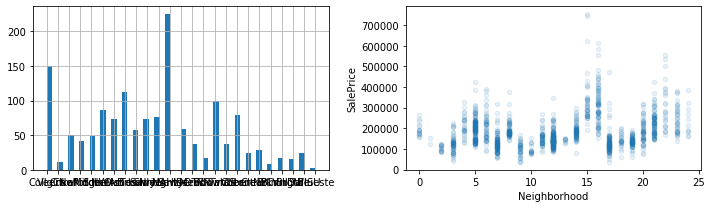

Foundation:  Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
6 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: Foundation, dtype: float64


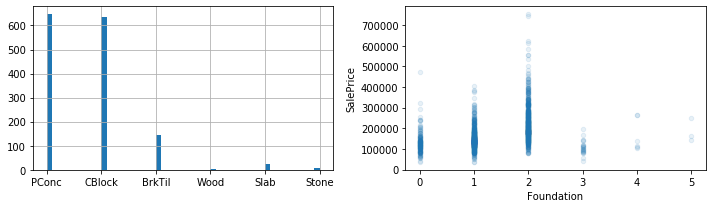

BsmtQual:  Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
4 unique values
Correlation with sale price:
 corr      0.0
nozero    0.0
Name: BsmtQual, dtype: float64


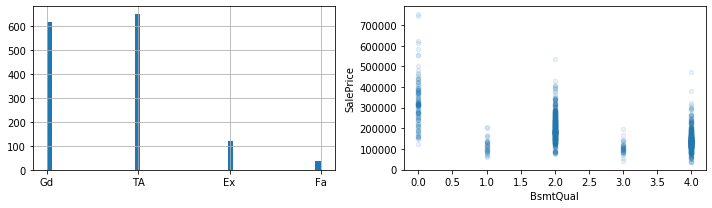

MSSubClass:  Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

15 unique values
Correlation with sale price:
 corr     -0.084284
nozero   -0.084284
Name: MSSubClass, dtype: float64


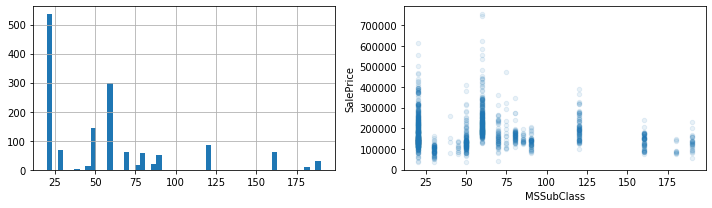

In [312]:
# Same plot as earlier, using only interesting features
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

nunique_values = housing.nunique().sort_values(ascending=False)

for feature_name, corrs in y_corr['nozero'][to_keep].sort_values(ascending=False).iteritems():

    # Print feature description, number of unique values and correlation with sale price
    if feature_name in dct_features.keys():
         print('%s: %s' % (feature_name, dct_features[feature_name]))
    else:
         print(feature_name)
    print('%s unique values' % nunique_values[feature_name])
    print('Correlation with sale price:\n', y_corr.loc[feature_name])
    
    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
    # Figure 1 (left)
    housing[feature_name].hist(bins=50, ax=ax[0])
    
    # Figure 2 (right)
    if housing[feature_name].dtype != 'O':
        housing.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
    else:
        le = LabelEncoder()
        encoded_feature = pd.DataFrame(
            {'SalePrice': housing['SalePrice'],
             feature_name: le.fit_transform(housing[feature_name].fillna('NA') )
            })
        
        encoded_feature.plot.scatter(y='SalePrice', x=feature_name, ax=ax[1], alpha=0.1)
    
    plt.tight_layout()
    plt.show()

### House size

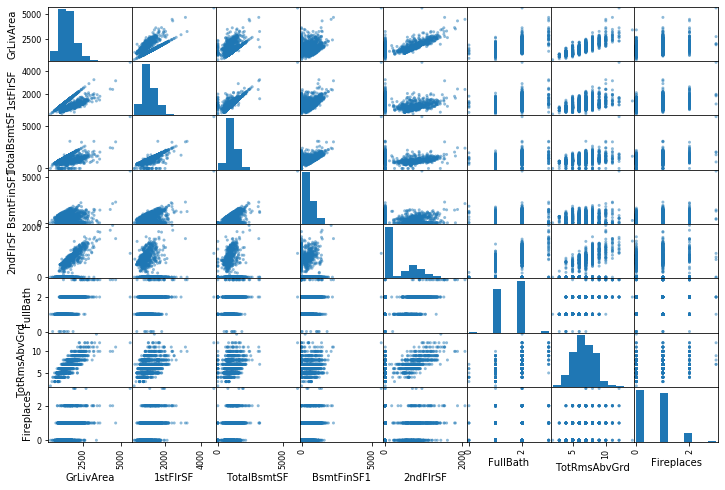

In [353]:
from pandas.plotting import scatter_matrix

living_area = housing[['SalePrice', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'BsmtFinSF1',
                         '2ndFlrSF', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']].copy()
scatter_matrix(living_area.drop('SalePrice', axis=1), figsize=(12, 8))
plt.show()

GrLivArea seems to determine the size of 1st floor, basement, 2nd floor and total number of rooms.
- 1stFlrSF: perfectly linear (when there is only one floor)
- 2ndFlrSF: mostly linear (when there is a 2nd floor)
- Basement: If there is one then price increase

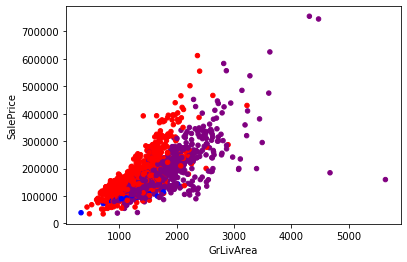

In [436]:
living_area['is2nd'] = living_area['2ndFlrSF'] > 0
living_area['color'] = np.where(
    living_area['2ndFlrSF'] > 0, 'purple', np.where(
        living_area['TotalBsmtSF'] > 0, 'red', np.where(
            living_area['1stFlrSF'] > 0, 'blue', 'black'
        ))).copy()

living_area.plot.scatter(y='SalePrice', x='GrLivArea', c=living_area['color'])

In [397]:
# Simple linear regression model

from sklearn.linear_model import LinearRegression

def lin_reg(X, y):
    lr = LinearRegression()

    from sklearn.model_selection import cross_validate
    scores = cross_validate(lr, X, y, scoring=["neg_mean_squared_error", "r2"], cv=10)
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2 = scores['test_r2']
    r2_adj = 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)
    
    print('RMSE: (%f, %f)' % (rmse.mean(), rmse.std()))
    print('r2: (%f, %f)' % (r2.mean(), r2.std()))
    print('r2-adj: (%f, %f)' % (r2_adj.mean(), r2_adj.std()))

In [398]:
X = living_area[['GrLivArea']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (55616.283215, 8313.475161)
r2: (0.499674, 0.080594)
r2-adj: (0.499331, 0.080650)


In [399]:
X = living_area[['GrLivArea', 'is2nd']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (51759.474778, 8183.174119)
r2: (0.565355, 0.083839)
r2-adj: (0.564759, 0.083954)


In [430]:
X = living_area[['TotalBsmtSF', '2ndFlrSF']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (51928.236039, 11797.267068)
r2: (0.560059, 0.152600)
r2-adj: (0.559455, 0.152810)


In [435]:
X = living_area[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'Fireplaces']]
y = living_area['SalePrice']

lin_reg(X, y)

RMSE: (47145.304498, 11237.499937)
r2: (0.636153, 0.134530)
r2-adj: (0.634902, 0.134993)


#### Conclusion:

##### Use:
    - TotalBsmtSF, 1stFlrSF and 2ndFlrSF together
    - FullBath (number of bathrooms)
    - Fireplaces
    
##### Drop:
    - GrLivArea
    - TotalBsmtSF
    - BsmtFinSF1

### Garage correlated features

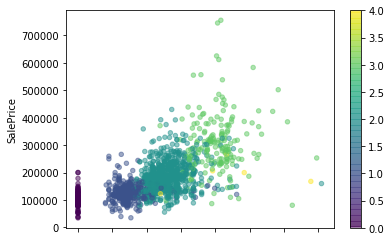

In [351]:
garage = housing[['SalePrice', 'GarageArea', 'GarageCars', 'GarageYrBlt']].copy()

garage.plot.scatter(y='SalePrice', x='GarageArea',
                    c=garage['GarageCars'],
                    colormap='viridis', alpha=0.5)

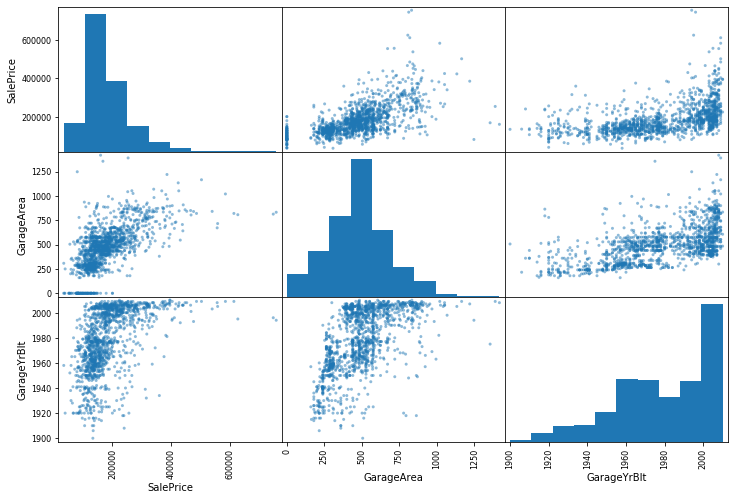

In [445]:
scatter_matrix(garage.drop('GarageCars', axis=1), figsize=(12, 8));

#### Conclusion:

##### Use:
    - GarageCars
    
##### Drop:
    - GarageArea
    - GarageYrBlt

### Quality

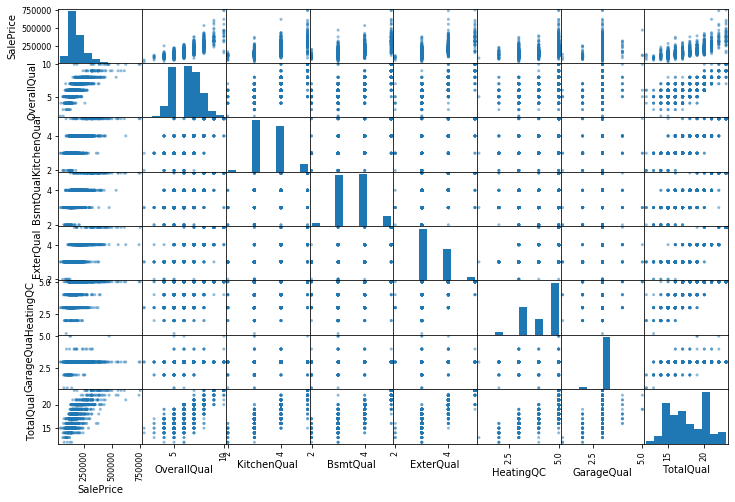

In [478]:
quality = housing[['SalePrice', 'OverallQual', 'KitchenQual', 'BsmtQual',
                     'ExterQual', 'HeatingQC', 'GarageQual']].dropna()

quality_map = {'Ex': 5,
               'Gd': 4,
               'TA': 3,
               'Fa': 2,
               'Po': 1}

qual_cols = ['KitchenQual', 'BsmtQual', 'ExterQual', 'HeatingQC', 'GarageQual']

for col in qual_cols:
    quality[col] = quality[col].map(quality_map)

quality['TotalQual'] = quality[qual_cols].sum(axis=1)

scatter_matrix(quality, figsize=(12, 8));

In [490]:
X = quality[['OverallQual']]
y = quality['SalePrice']

lin_reg(X, y)

RMSE: (48746.370435, 5775.121769)
r2: (0.613322, 0.043381)
r2-adj: (0.613035, 0.043413)


In [491]:
X = quality[['KitchenQual', 'BsmtQual', 'ExterQual', 'HeatingQC', 'GarageQual']]
y = quality['SalePrice']

lin_reg(X, y)

RMSE: (51890.282842, 6116.016924)
r2: (0.562432, 0.042724)
r2-adj: (0.560803, 0.042883)


In [492]:
X = quality[['OverallQual', 'KitchenQual']]
y = quality['SalePrice']

lin_reg(X, y)

RMSE: (46872.069457, 5738.518095)
r2: (0.642459, 0.043382)
r2-adj: (0.641927, 0.043446)


#### Conclusion:

##### Use:
    - OverallQual
    - KitchenQual
    
##### Drop:
    - BsmtQual
    - ExterQual
    - HeatingQC
    - GarageQual

# Preprocessing

In [894]:
housing = pd.read_csv('data/train.csv')

num_features = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'YearBuilt']
num_cat_features = ['Fireplaces', 'GarageCars', 'FullBath']
cat_features = ['KitchenQual', 'Neighborhood', 'MSSubClass', 'Foundation']

### Cat features

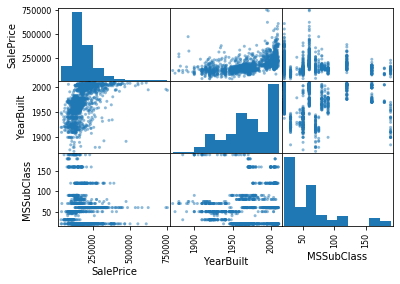

In [860]:
housing_cat = housing[['SalePrice', 'YearBuilt'] + cat_features].copy()

scatter_matrix(housing_cat)
plt.show()

#### MSSubClass

In [861]:
# Convert to category
housing_cat['MSSubClass'] = housing_cat['MSSubClass'].astype('category')

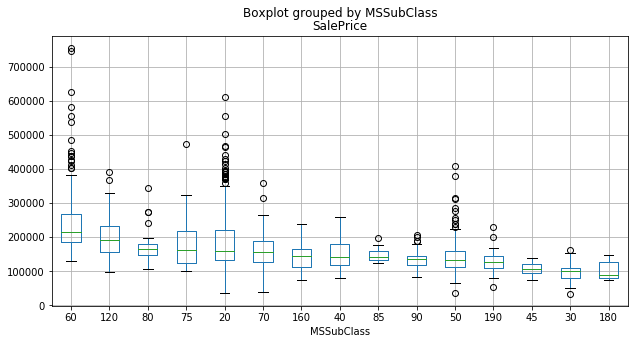

[(60, 299), (120, 87), (80, 58), (75, 16), (20, 536), (70, 60), (160, 63), (40, 4), (85, 20), (90, 52), (50, 144), (190, 30), (45, 12), (30, 69), (180, 10)]

 Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



In [862]:
## 1. Normal boxplot

# Order by mean SalePrice
ordered_MS = housing_cat.groupby('MSSubClass').median().sort_values(by='SalePrice', ascending=False).index
housing_cat['MSSubClass'] = housing_cat['MSSubClass'].cat.reorder_categories(list(ordered_MS))

# Boxplot
housing_cat.boxplot(column='SalePrice', by='MSSubClass', figsize=(10, 5))
plt.show()

# Value counts
print(list(dict(housing_cat['MSSubClass'].value_counts().sort_index()).items()), end='\n\n')

# Feature description
print(dct_features['MSSubClass'])

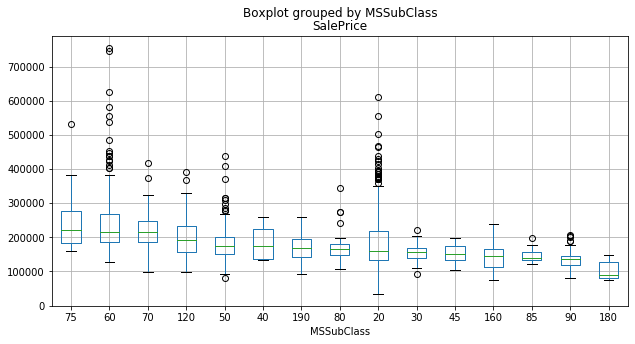

[(60, 299), (120, 87), (80, 58), (75, 16), (20, 536), (70, 60), (160, 63), (40, 4), (85, 20), (90, 52), (50, 144), (190, 30), (45, 12), (30, 69), (180, 10)]

 Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



In [863]:
## 2. Adjust price based on before or after 1945

old_build = housing.loc[housing['YearBuilt'] <= 1945, 'SalePrice'].mean()
new_build = housing.loc[housing['YearBuilt'] >= 1946, 'SalePrice'].mean()
price_diff = new_build - old_build

housing_cat_adj = housing_cat.copy()
housing_cat_adj.loc[housing_cat_adj['YearBuilt'] <= 1945, 'SalePrice'] += price_diff

# Order by mean SalePrice
ordered_MS = housing_cat_adj.groupby('MSSubClass').median().sort_values(by='SalePrice', ascending=False).index
housing_cat_adj['MSSubClass'] = housing_cat_adj['MSSubClass'].cat.reorder_categories(list(ordered_MS))

# Boxplot
housing_cat_adj.boxplot(column='SalePrice', by='MSSubClass', figsize=(10, 5))
plt.show()

# Value counts
print(list(dict(housing_cat['MSSubClass'].value_counts().sort_index()).items()), end='\n\n')

# Feature description
print(dct_features['MSSubClass'])

In [984]:
housing_cat['1-STORY'] = housing_cat['MSSubClass'].isin([20, 30, 40, 120])
housing_cat['1-1/2-STORY'] = housing_cat['MSSubClass'].isin([45, 50, 150])
housing_cat['2-STORY'] = housing_cat['MSSubClass'].isin([60, 70, 160])
housing_cat['2-1/2-STORY'] = housing_cat['MSSubClass'].isin([75])
housing_cat['SPLIT'] = housing_cat['MSSubClass'].isin([80, 85, 180])
housing_cat['PUD'] = housing_cat['MSSubClass'].isin([120, 150, 160, 180])
housing_cat['DUPLEX'] = housing_cat['MSSubClass'].isin([90])
housing_cat['2FAMILY'] = housing_cat['MSSubClass'].isin([190])

#### Quality

In [865]:
quality_map = {'Ex': 5,
               'Gd': 4,
               'TA': 3,
               'Fa': 2,
               'Po': 1}

housing_cat['KitchenQual'] = housing_cat['KitchenQual'].map(quality_map)

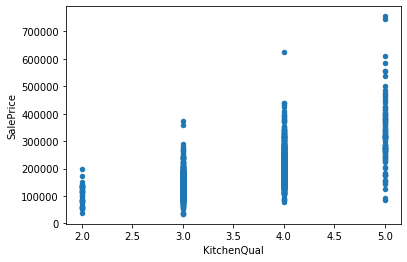

In [867]:
housing_cat.plot.scatter(y='SalePrice', x='KitchenQual');

#### Foundation and Neighborhood

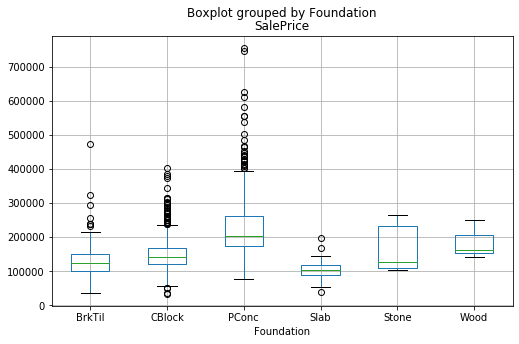

In [890]:
housing_cat.boxplot(column='SalePrice', by='Foundation', figsize=(8, 5));

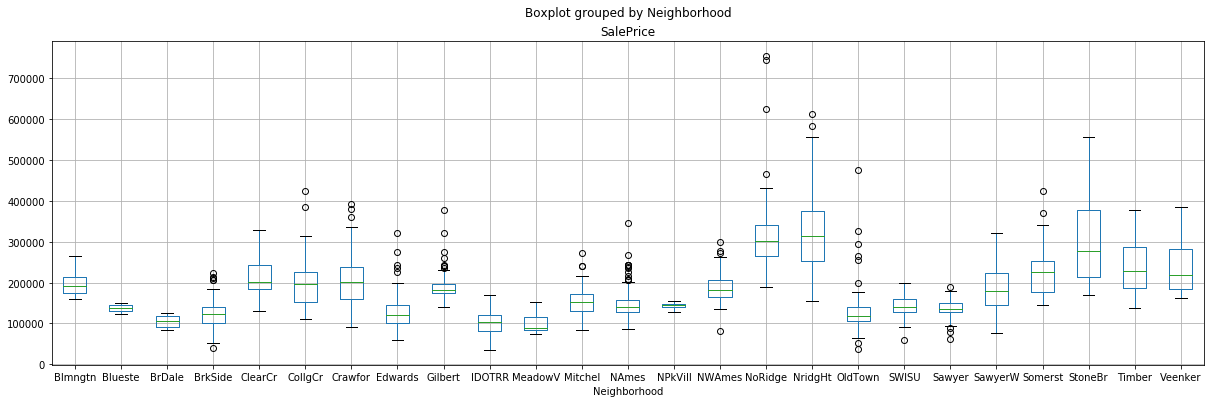

In [888]:
housing_cat.boxplot(column='SalePrice', by='Neighborhood', figsize=(20, 6));

In [891]:
ohe = OneHotEncoder()

ohe.fit_transform(housing_cat[['Foundation', 'Neighborhood']])

<1460x31 sparse matrix of type '<class 'numpy.float64'>'
	with 2920 stored elements in Compressed Sparse Row format>

### Numeric cat features

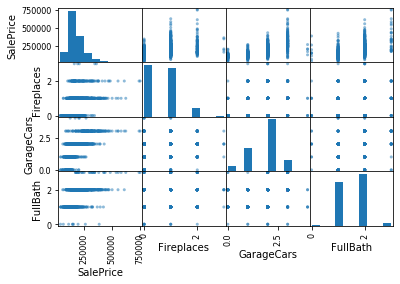

In [574]:
housing_num_cat = housing[['SalePrice'] + num_cat_features].copy()

scatter_matrix(housing_num_cat)
plt.show()

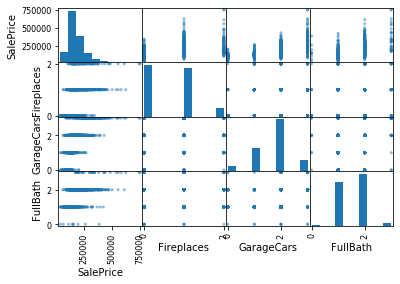

In [577]:
# Combine categorical feature instances with low frequency
housing_num_cat.loc[housing_num_cat['Fireplaces'] > 2, 'Fireplaces'] = 2
housing_num_cat.loc[housing_num_cat['GarageCars'] > 3, 'GarageCars'] = 3

scatter_matrix(housing_num_cat)
plt.show()

### Numeric features

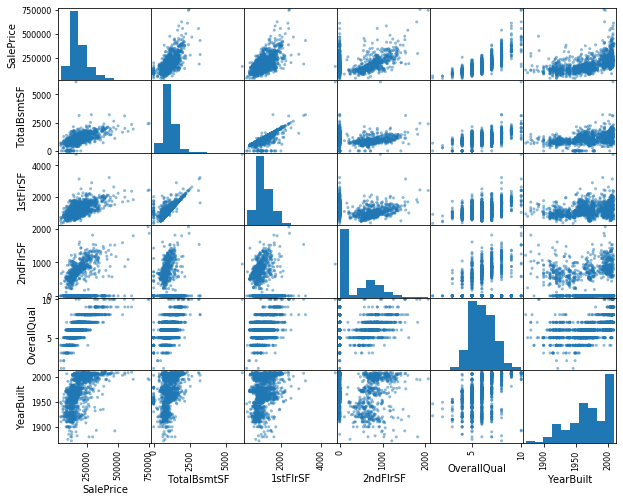

In [895]:
housing_num = housing[['SalePrice'] + num_features]

scatter_matrix(housing_num, figsize=(10, 8))
plt.show()

# Pipeline 

In [905]:
housing = pd.read_csv('data/train.csv')
housing.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [933]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    housing.drop('SalePrice', axis=1),
    housing['SalePrice']
)

In [990]:
# Numeric transformer
from sklearn.base import BaseEstimator, TransformerMixin

class DiscreteCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, idx_Fireplaces, idx_GarageCars):
        self.idx_Fireplaces = idx_Fireplaces
        self.idx_GarageCars = idx_GarageCars
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        X[X[:, self.idx_Fireplaces] > 2, self.idx_Fireplaces] = 2
        X[X[:, self.idx_GarageCars] > 3, self.idx_GarageCars] = 3
        return X        

In [1077]:
# Categorical to numeric transformer
class QualityMapper(BaseEstimator, TransformerMixin):
    def __init__(self, idx_KitchenQual):
        self.idx_KitchenQual = idx_KitchenQual
        quality_map = {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        }
        self.map_quality = np.vectorize(quality_map.get)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        X[:, idx_KitchenQual] = self.map_quality(X[:, idx_KitchenQual])
        
        return X

In [1081]:
# Numeric pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_features = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'YearBuilt',
                'FullBath', 'Fireplaces', 'GarageCars', 'KitchenQual']

idx_fireplaces = num_features.index('Fireplaces')
idx_garagecars = num_features.index('GarageCars')
idx_KitchenQual = num_features.index('KitchenQual')

num_pipeline = Pipeline([
    ('quality_mapper', QualityMapper(idx_KitchenQual)),
    ('discrete_cleaner', DiscreteCleaner(idx_fireplaces, idx_garagecars)),
    ('std_scaler', StandardScaler())
])

In [1113]:
# Categorical custom OHE
from sklearn.base import BaseEstimator, TransformerMixin

class MSSubClassOHE(BaseEstimator, TransformerMixin):
    def __init__(self, idx_MSSubClass):
        self.idx_MSSubClass = idx_MSSubClass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        one_story = np.isin(X[:, idx_MSSubClass], [20, 30, 40, 120])
        one_half_story = np.isin(X[:, idx_MSSubClass], [45, 50, 150])
        two_story = np.isin(X[:, idx_MSSubClass], [60, 70, 160])
        two_half_story = np.isin(X[:, idx_MSSubClass], [75])
        split = np.isin(X[:, idx_MSSubClass], [80, 85, 180])
        pud = np.isin(X[:, idx_MSSubClass], [120, 150, 160, 180])
        duplex = np.isin(X[:, idx_MSSubClass], [90])
        two_family = np.isin(X[:, idx_MSSubClass], [190])
        
        return np.c_[np.delete(X, idx_MSSubClass, axis=1), one_story, one_half_story,
                     two_story, two_half_story, split, pud, duplex, two_family]       
    

In [1114]:
# Categorical custom OHE pipeline
cat_features = ['MSSubClass']

idx_MSSubClass = cat_features.index('MSSubClass')

cat_pipeline = Pipeline([
    ('ms_subclass_simplifier', MSSubClassOHE(idx_MSSubClass)),
])

In [1182]:
# OHE pipeline 
from sklearn.preprocessing import OneHotEncoder

ohe_features = ['Neighborhood', 'Foundation']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('ohe', OneHotEncoder(), ohe_features),
])

X_train_pp = full_pipeline.fit_transform(X_train)

# Modeling 

In [1183]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train_pp, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

rmse_scores.mean()

33833.1886713725

In [1184]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

scores = cross_val_score(rf_reg, X_train_pp, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

rmse_scores.mean()

29835.63852937236

In [1185]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bootstrap': [False, True], 
     'n_estimators': [20, 30, 40, 50, 60],
     'max_features': [2, 4, 6, 8]
    },
]

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(
    rf_reg,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(X_train_pp, y_train)

print(grid_search.best_params_, end='\n\n')

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'bootstrap': False, 'max_features': 6, 'n_estimators': 60}

31129.898108381258 {'bootstrap': False, 'max_features': 2, 'n_estimators': 20}
30808.274119311143 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
30855.418868921926 {'bootstrap': False, 'max_features': 2, 'n_estimators': 40}
30278.659143698314 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
30700.813406312554 {'bootstrap': False, 'max_features': 2, 'n_estimators': 60}
31901.675843538982 {'bootstrap': False, 'max_features': 4, 'n_estimators': 20}
30310.74720080285 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
31187.054348374622 {'bootstrap': False, 'max_features': 4, 'n_estimators': 40}
30440.02902825853 {'bootstrap': False, 'max_features': 4, 'n_estimators': 50}
30301.11279709568 {'bootstrap': False, 'max_features': 4, 'n_estimators': 60}
30669.701898508818 {'bootstrap': False, 'max_features': 6, 'n_estimators': 20}
30992.08535342523 {'bootstrap': False, 'max_features': 6, 'n_estimators':

In [1186]:
# Random Forest feature importances
feature_importances = grid_search.best_estimator_.feature_importances_

mssubclass_features = ['one_story', 'one_half_story', 'two_story', 'two_half_story', 'split',
                       'pud', 'duplex', 'two_family'] 

ohe_encoder = full_pipeline.named_transformers_["ohe"]
ohe_features = list(np.concatenate(ohe_encoder.categories_))

feature_names = num_features + mssubclass_features + ohe_features 

sorted(zip(feature_importances, feature_names), reverse=True)

[(0.1583343475978647, 'OverallQual'),
 (0.1264432006851553, 'TotalBsmtSF'),
 (0.11625444234451801, '1stFlrSF'),
 (0.0965589746243018, 'GarageCars'),
 (0.08983570186267407, 'YearBuilt'),
 (0.08217094472957072, '2ndFlrSF'),
 (0.07909109679718071, 'KitchenQual'),
 (0.05709505573213801, 'FullBath'),
 (0.035408505354271355, 'Fireplaces'),
 (0.01929653058810272, 'PConc'),
 (0.018743810711979246, 'NridgHt'),
 (0.01613995873106461, 'NoRidge'),
 (0.01471416517751007, 'two_story'),
 (0.009457639929824747, 'CBlock'),
 (0.007605673761085564, 'pud'),
 (0.006950182480922409, 'one_story'),
 (0.005987559592361135, 'Edwards'),
 (0.005186247993071154, 'StoneBr'),
 (0.005090341478412049, 'BrkTil'),
 (0.004837124738034963, 'NAmes'),
 (0.0046044714243746255, 'OldTown'),
 (0.0046021179366368984, 'Crawfor'),
 (0.0036066726735004594, 'ClearCr'),
 (0.00317454160692904, 'one_half_story'),
 (0.003057891157754161, 'IDOTRR'),
 (0.0027602418069219755, 'Somerst'),
 (0.0026306636077351024, 'CollgCr'),
 (0.00238696271

In [1192]:
X_train_pp[0]

array([ 0.14471337,  0.40994427,  0.72669022, -1.52745545, -1.43350812,
        0.79483863,  2.17894761,  0.32838991,  0.75712559,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [1193]:
X_test_pp[0]

array([ 0.84123624,  0.69492245,  2.54989499, -0.06286375, -1.89890721,
        0.79483863, -0.96252393, -2.41654866, -2.29647485,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [1191]:
X_test_pp = full_pipeline.transform(X_test)

y_pred = grid_search.best_estimator_.predict(X_test_pp)
test_mse = mean_squared_error(y_test, y_pred)
np.sqrt(test_mse)

31261.260630564495

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]